### Use Keras Models

In [13]:
%matplotlib inline
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from os import listdir, makedirs
from os.path import join, exists, expanduser
from tqdm import tqdm
from sklearn.metrics import log_loss, accuracy_score
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications import xception
from keras.applications import inception_v3
from keras.applications.vgg16 import preprocess_input, decode_predictions
from sklearn.linear_model import LogisticRegression

In [2]:
INPUT_SIZE = 224
NUM_CLASSES = 16
SEED = 9999

In [11]:
labels = pd.read_csv('labels.csv')
sample_submission = pd.read_csv('sample_submission.csv')
print(len(listdir('train')), len(labels))
print(len(listdir('test')), len(sample_submission))

10222 10222
10357 10357


In [14]:
# rank
group = pd.DataFrame(data=None, index = labels.id, columns = ['rank'])
for b in labels.groupby('breed').count().index:
    group['rank'][labels[labels['breed'] == b].id.rank().index] = labels[labels['breed'] == b].id.rank()
group.reset_index(level=0)
labels = pd.merge(labels, group, on = 'id')

In [15]:
# Selected breed: top 16
selected_breed_list = list(labels.groupby('breed').count().sort_values(by='id', ascending=False).head(NUM_CLASSES).index)
labels = labels[labels['breed'].isin(selected_breed_list)]
labels['target'] = 1

In [16]:
# pivot matrix: breed name becomes target of each breeds.
labels_pivot = labels.pivot('id', 'breed', 'target').reset_index().fillna(0) 
np.random.seed(seed=SEED)
rnd = np.random.random(len(labels))
# train : valid = 8:2
train_idx = rnd < 0.8 # true false form
valid_idx = rnd >= 0.8
y_train = labels_pivot[selected_breed_list].values #target values
ytr = y_train[train_idx]
yv = y_train[valid_idx]

In [19]:
# I like these kind of comments
def read_img(img_id, train_or_test, size):
    """Read and resize image.
    # Arguments
        img_id: string
        train_or_test: string 'train' or 'test'.
        size: resize the original image.
    # Returns
        Image as numpy array.
    """
    img = image.load_img(join(train_or_test, '%s.jpg' % img_id), target_size=size)
    img = image.img_to_array(img)
    return img

## Use 4 CNN models (ResNet50, VGG16, Xception, Inception)

### 1. ResNet50 class predictions for example images

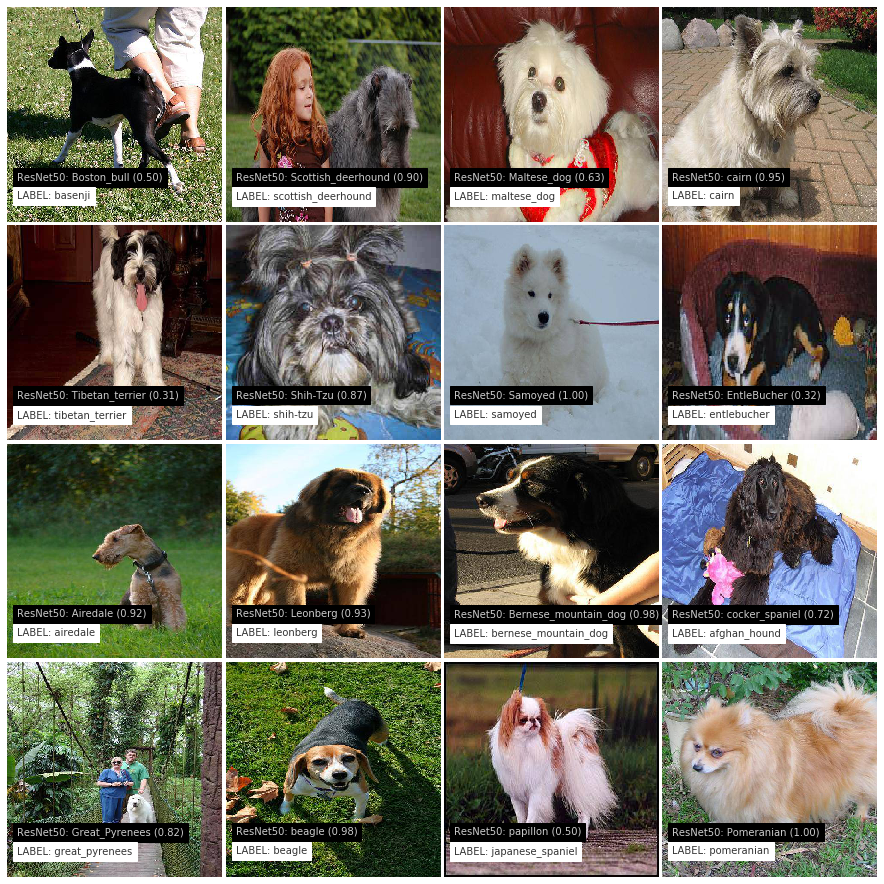

In [26]:
model = ResNet50(weights='imagenet')
j = int(np.sqrt(NUM_CLASSES)) #columns
i = int(np.ceil(1. * NUM_CLASSES / j)) #rows: ceiling(올림)
fig = plt.figure(1, figsize=(16, 16))
grid = ImageGrid(fig, 111, nrows_ncols=(i, j), axes_pad=0.05) # matplotlib 
for i, (img_id, breed) in enumerate(labels.loc[labels['rank'] == 1, ['id', 'breed']].values): # get first image from each breed.
    ax = grid[i]
    img = read_img(img_id, 'train', (224, 224))
    ax.imshow(img / 255.) # normalize rgb value.
    x = preprocess_input(np.expand_dims(img.copy(), axis=0)) # preprocess input to fit resnet input
    preds = model.predict(x) # predict using resnet50 model
    _, imagenet_class_name, prob = decode_predictions(preds, top=1)[0][0] # ?(useless) ,classname, probability
    ax.text(10, 180, 'ResNet50: %s (%.2f)' % (imagenet_class_name , prob), color='w', backgroundcolor='k', alpha=0.8)
    ax.text(10, 200, 'LABEL: %s' % breed, color='k', backgroundcolor='w', alpha=0.8)
    ax.axis('off')
plt.show()

### 2-1. Bottleneck features of VGG 16

In [8]:
# the "bottleneck features" from the VGG16 model: the last activation maps before the fully-connected layers.

In [34]:
# (1) use preprocess_input to vgg16
INPUT_SIZE = 224
POOLING = 'avg' # average pooling
x_train = np.zeros((len(labels), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32') # zero matrix for reading images
for i, img_id in tqdm(enumerate(labels['id'])): #상태바 표시하기 
    img = read_img(img_id, 'train', (INPUT_SIZE, INPUT_SIZE))
    x = preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_train[i] = x # preprocess each inputs to fit the model
print('Train Images shape: {} size: {:,}'.format(x_train.shape, x_train.size))

1777it [00:34, 50.80it/s]


Train Images shape: (1777, 224, 224, 3) size: 267,488,256


In [36]:
Xtr = x_train[train_idx]
Xv = x_train[valid_idx]
print((Xtr.shape, Xv.shape, ytr.shape, yv.shape))
vgg_bottleneck = VGG16(weights='imagenet', include_top=False, pooling=POOLING) # without last 3 fc-layers.
train_vgg_bf = vgg_bottleneck.predict(Xtr, batch_size=32, verbose=1) #verbose mode.
valid_vgg_bf = vgg_bottleneck.predict(Xv, batch_size=32, verbose=1)
print('VGG train bottleneck features shape: {} size: {:,}'.format(train_vgg_bf.shape, train_vgg_bf.size))
print('VGG valid bottleneck features shape: {} size: {:,}'.format(valid_vgg_bf.shape, valid_vgg_bf.size))

((1431, 224, 224, 3), (346, 224, 224, 3), (1431, 16), (346, 16))
346/346 [==============================] - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 56s - ETA: 47 - ETA: 39 - ETA: 31 - ETA: 23 - ETA: 14 - ETA: 6 - 89s 257ms/step
VGG train bottleneck features shape: (1431, 512) size: 732,672
VGG valid bottleneck features shape: (346, 512) size: 177,152


### 2-2. Logistic Regression on VGG bottleneck features

In [53]:
# Just using last layer as logreg?
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=SEED)
logreg.fit(train_vgg_bf, (ytr * range(NUM_CLASSES)).sum(axis=1)) # right argument makes 1437 output to 16 classes
valid_probs = logreg.predict_proba(valid_vgg_bf)
valid_preds = logreg.predict(valid_vgg_bf)

C:\Users\Moon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [54]:
print('Validation VGG LogLoss {}'.format(log_loss(yv, valid_probs)))
print('Validation VGG Accuracy {}'.format(accuracy_score((yv * range(NUM_CLASSES)).sum(axis=1), valid_preds)))

Validation VGG LogLoss 0.5708842522559996
Validation VGG Accuracy 0.8959537572254336


### 3-1. Extract Xception bottleneck features

In [63]:
# same as vgg16
INPUT_SIZE = 299
POOLING = 'avg'
x_train = np.zeros((len(labels), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
for i, img_id in tqdm(enumerate(labels['id'])):
    img = read_img(img_id, 'train', (INPUT_SIZE, INPUT_SIZE))
    x = xception.preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_train[i] = x
print('Train Images shape: {} size: {:,}'.format(x_train.shape, x_train.size))

1777it [00:11, 160.21it/s]


Train Images shape: (1777, 299, 299, 3) size: 476,596,731


In [64]:
Xtr = x_train[train_idx]
Xv = x_train[valid_idx]
print((Xtr.shape, Xv.shape, ytr.shape, yv.shape))
xception_bottleneck = xception.Xception(weights='imagenet', include_top=False, pooling=POOLING)
train_x_bf = xception_bottleneck.predict(Xtr, batch_size=32, verbose=1)
valid_x_bf = xception_bottleneck.predict(Xv, batch_size=32, verbose=1)
print('Xception train bottleneck features shape: {} size: {:,}'.format(train_x_bf.shape, train_x_bf.size))
print('Xception valid bottleneck features shape: {} size: {:,}'.format(valid_x_bf.shape, valid_x_bf.size))

((1431, 299, 299, 3), (346, 299, 299, 3), (1431, 16), (346, 16))
346/346 [==============================] - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 49s - ETA: 31 - ETA: 14 - 190s 549ms/step
Xception train bottleneck features shape: (1431, 2048) size: 2,930,688
Xception valid bottleneck features shape: (346, 2048) size: 708,608


### 3-2. Logistic Regression on Xception bottleneck features

In [15]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=SEED)
logreg.fit(train_x_bf, (ytr * range(NUM_CLASSES)).sum(axis=1))
valid_probs = logreg.predict_proba(valid_x_bf)
valid_preds = logreg.predict(valid_x_bf)
print('Validation Xception LogLoss {}'.format(log_loss(yv, valid_probs)))
print('Validation Xception Accuracy {}'.format(accuracy_score((yv * range(NUM_CLASSES)).sum(axis=1), valid_preds)))

C:\Users\Moon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Validation Xception LogLoss 0.07245281179807721
Validation Xception Accuracy 0.9826589595375722


### 4-1. Extract Inception bottleneck features

In [16]:
Xtr = x_train[train_idx]
Xv = x_train[valid_idx]
print((Xtr.shape, Xv.shape, ytr.shape, yv.shape))
inception_bottleneck = inception_v3.InceptionV3(weights='imagenet', include_top=False, pooling=POOLING)
train_i_bf = inception_bottleneck.predict(Xtr, batch_size=32, verbose=1)
valid_i_bf = inception_bottleneck.predict(Xv, batch_size=32, verbose=1)
print('InceptionV3 train bottleneck features shape: {} size: {:,}'.format(train_i_bf.shape, train_i_bf.size))
print('InceptionV3 valid bottleneck features shape: {} size: {:,}'.format(valid_i_bf.shape, valid_i_bf.size))

((1431, 299, 299, 3), (346, 299, 299, 3), (1431, 16), (346, 16))


W0909 20:42:23.693415  3096 deprecation_wrapper.py:119] From C:\Users\Moon\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3980: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.



346/346 [==============================] - ETA: 1: - ETA: 1: - ETA: 58s - ETA: 51 - ETA: 44 - ETA: 36 - ETA: 29 - ETA: 21 - ETA: 13 - ETA: 6 - 82s 237ms/step
InceptionV3 train bottleneck features shape: (1431, 2048) size: 2,930,688
InceptionV3 valid bottleneck features shape: (346, 2048) size: 708,608


### 4-2. Logistic Regression on Extract Inception bottleneck features

In [17]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=SEED)
logreg.fit(train_i_bf, (ytr * range(NUM_CLASSES)).sum(axis=1))
valid_probs = logreg.predict_proba(valid_i_bf)
valid_preds = logreg.predict(valid_i_bf)

C:\Users\Moon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [18]:
print('Validation Inception LogLoss {}'.format(log_loss(yv, valid_probs)))
print('Validation Inception Accuracy {}'.format(accuracy_score((yv * range(NUM_CLASSES)).sum(axis=1), valid_preds)))

Validation Inception LogLoss 0.09859586393841668
Validation Inception Accuracy 0.9624277456647399


### 5. LogReg on all bottleneck features

In [19]:
X = np.hstack([train_x_bf, train_i_bf]) # stack features(xception, inception) horizontally
V = np.hstack([valid_x_bf, valid_i_bf])
print('Full train bottleneck features shape: {} size: {:,}'.format(X.shape, X.size))
print('Full valid bottleneck features shape: {} size: {:,}'.format(V.shape, V.size))
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=SEED)
logreg.fit(X, (ytr * range(NUM_CLASSES)).sum(axis=1))
valid_probs = logreg.predict_proba(V)
valid_preds = logreg.predict(V)
print('Validation Xception + Inception LogLoss {}'.format(log_loss(yv, valid_probs)))
print('Validation Xception + Inception Accuracy {}'.format(accuracy_score((yv * range(NUM_CLASSES)).sum(axis=1), valid_preds)))

Full train bottleneck features shape: (1431, 4096) size: 5,861,376
Full valid bottleneck features shape: (346, 4096) size: 1,417,216


C:\Users\Moon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Validation Xception + Inception LogLoss 0.08265495149570354
Validation Xception + Inception Accuracy 0.9739884393063584


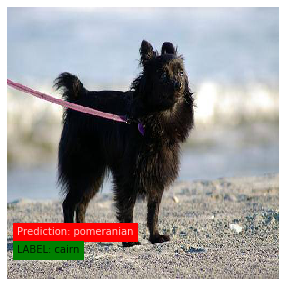

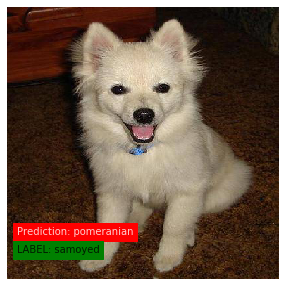

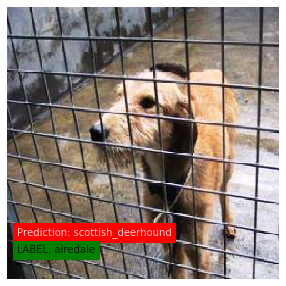

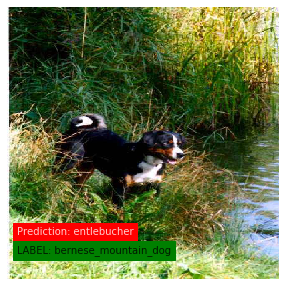

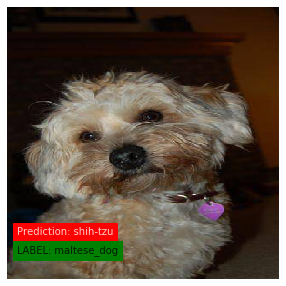

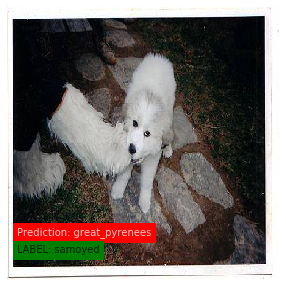

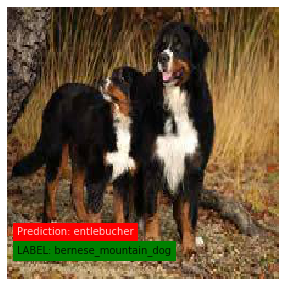

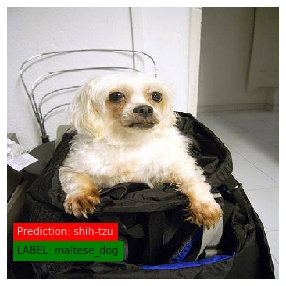

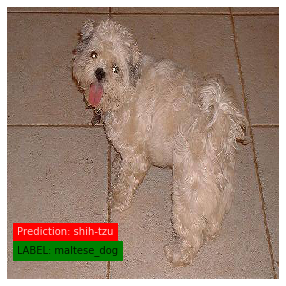

In [20]:
valid_breeds = (yv * range(NUM_CLASSES)).sum(axis=1)
error_idx = (valid_breeds != valid_preds)
for img_id, breed, pred in zip(labels.loc[valid_idx, 'id'].values[error_idx],
                                [selected_breed_list[int(b)] for b in valid_preds[error_idx]],
                                [selected_breed_list[int(b)] for b in valid_breeds[error_idx]]):
    fig, ax = plt.subplots(figsize=(5,5))
    img = read_img(img_id, 'train', (299, 299))
    ax.imshow(img / 255.)
    ax.text(10, 250, 'Prediction: %s' % pred, color='w', backgroundcolor='r', alpha=0.8)
    ax.text(10, 270, 'LABEL: %s' % breed, color='k', backgroundcolor='g', alpha=0.8)
    ax.axis('off')
    plt.show()      